## Aim

The goal of this report is to predict the ER status for those patients where the ER status is unknown. To this end I used the GEO metadata downloaded in [Downloading GEO data](r0_getdata.html) and the cluster assignments obtained in the report [Identification of breast cancer subtypes and biomarkers using the Seurat workflow](r3_clustering_seurat.qmd).


## Workflow

- I compared three supervised learning method (logist regression, random forest, support vector machine) optimizing their hyperparameters using a grid search with balanced accuracy as evaluation metric.

- To handle missing data, I used the [KNNimputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html), which imputes values based on the nearest neighbors in the feature space.

- For feature selection, I applied [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) to retain the most informative features with respect to the target variable (ER status).

- To address class imbalance, I set the parameter [class_weight=balanced](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) to ensure that the model gives appropriate attention to minority classes during training.


## Conclusion

In terms of balanced accuracy, random forest slightly outperformed logistic regression and SVM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from IPython.display import display, HTML

## Exploring dataset

### Loading dataset

In [2]:
df = pd.read_table('data/cluster_anno_seurat.csv', sep=',')

df = df[['patient', 'age_at_diagnosis', 'tumor_size',
         'lymph_node_status','er_status', 'pgr_status', 'her2_status',
         'pam50_subtype', 'overall_survival_days', 'overall_survival_event',
         'endocrine_treated', 'chemo_treated', 'ki67_status', 'nhg',
         'seurat_clusters']]

df = df.set_index('patient')

df = df.replace({'endocrine_treated': {'no treated': 'untreated'}})
df = df.replace({'chemo_treated': {'no treated': 'untreated'}})
df = df.replace({'overall_survival_event': {'no survival': 'nosurvival'}})

df

,age_at_diagnosis,tumor_size,lymph_node_status,er_status,pgr_status,her2_status,pam50_subtype,overall_survival_days,overall_survival_event,endocrine_treated,chemo_treated,ki67_status,nhg,seurat_clusters
patient,,,,,,,,,,,,,,
F1,43,9.0,NodeNegative,NaN,NaN,HER2-,Basal,2367,nosurvival,untreated,treated,NaN,G3,5
F2,48,14.0,NodePositive,ER+,PgR+,HER2-,LumA,2367,nosurvival,treated,treated,NaN,G2,0
F3,69,27.0,NodePositive,ER+,PgR+,HER2-,LumB,2168,survival,treated,treated,NaN,G3,1
F4,39,51.0,NodePositive,ER+,NaN,HER2+,LumA,2416,nosurvival,treated,treated,NaN,G3,4
F5,73,60.0,NodePositive,ER+,NaN,HER2-,Normal,2389,nosurvival,treated,untreated,NaN,G2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F3269,72,13.0,NodeNegative,ER+,PgR+,HER2-,LumB,856,nosurvival,treated,treated,Ki67+,G2,7
F3270,69,30.0,NodePositive,ER+,PgR+,HER2-,LumA,861,nosurvival,treated,treated,Ki67+,G2,8
F3271,73,18.0,NodeNegative,ER+,PgR-,NaN,LumB,862,nosurvival,treated,treated,Ki67+,G3,4


### Missing data Distribution

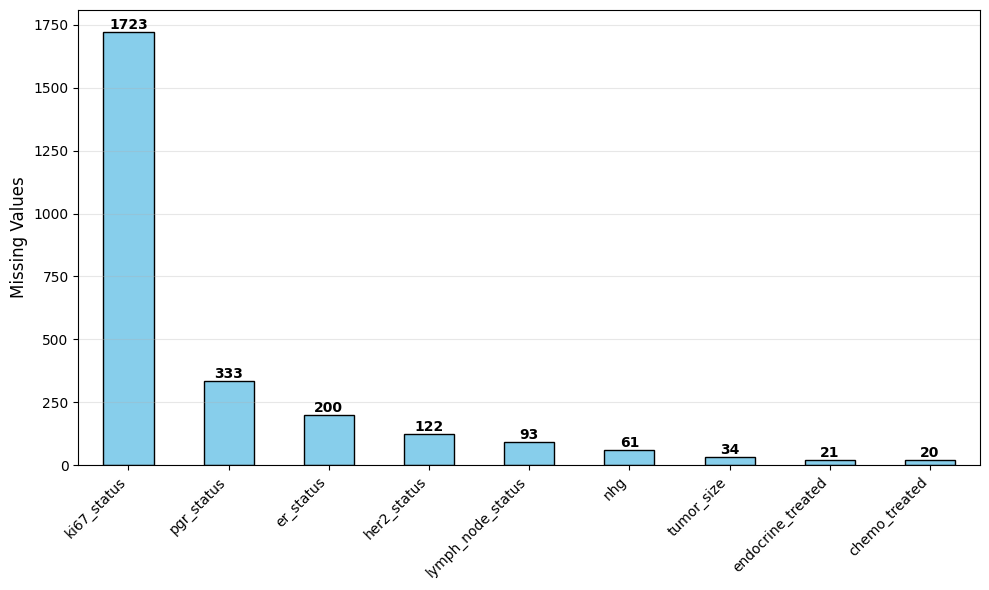

Tot features: 14
Tot features with missing values: 9 (64.3%)
Feature with missing values: ['ki67_status', 'pgr_status', 'er_status', 'her2_status', 'lymph_node_status', 'nhg', 'tumor_size', 'endocrine_treated', 'chemo_treated']
Feature without missing values: ['age_at_diagnosis', 'pam50_subtype', 'overall_survival_days', 'overall_survival_event', 'seurat_clusters']


In [3]:
features = df.columns

df_miss = df[features].isnull().sum()
df_miss = df_miss[df_miss > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
df_miss.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

plt.ylabel('Missing Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(df_miss.values):
  ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

missperc = (len(df_miss)/len(features))*100
print(f"Tot features: {len(features)}")
print(f"Tot features with missing values: {len(df_miss)} ({missperc:0.1f}%)")
print(f"Feature with missing values: {[col for col in df_miss.index]}")
print(f"Feature without missing values: {[col for col in df.columns if col not in df_miss.index]}")



### ER status distribution

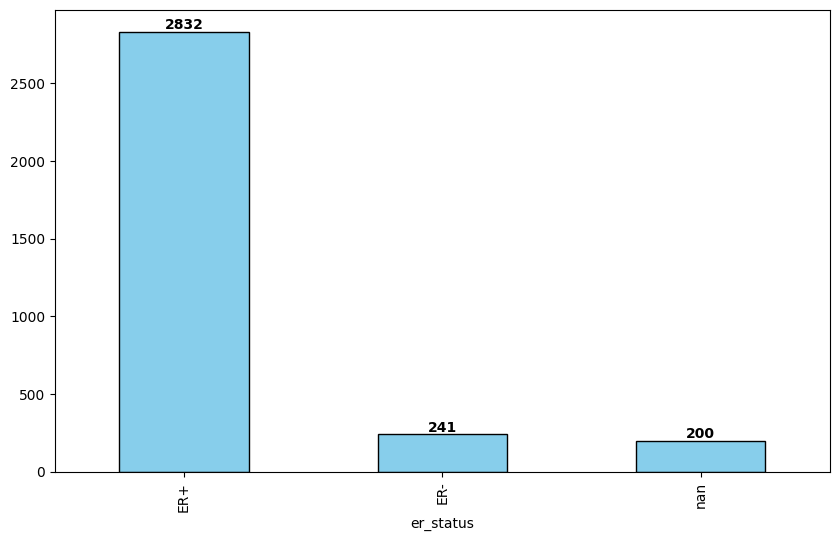

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
df['er_status'].value_counts(dropna=False).plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

for i, v in enumerate(df['er_status'].value_counts(dropna=False)):
  ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')


## Splitting data in training and test set

In [5]:
y = df['er_status']
X_train, y_train = df.loc[~y.isna(),:].drop('er_status', axis=1), y[~y.isna()]
X_test, y_test = df.loc[y.isna(),:].drop('er_status', axis=1), y[y.isna()]

## Imputation pipeline

In [28]:
def imputation_pipeline(X_train, classifier, nfeat = 5):
  # identify feature type
  categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
  numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

  # build imputation pipeline
  # OrdinalEncoder: designed for feature encoding, accept 2d array (X,y)
  # LabelEncoder: designed for target encoding, accept 1d array (y)
  categorical_imputer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('imputer', KNNImputer(n_neighbors=50))
  ])

  numerical_imputer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=20)),
    ('scaler', StandardScaler())
  ])

  imputation = ColumnTransformer(transformers=[
    ('categorical', categorical_imputer, categorical_features),
    ('numerical', numerical_imputer, numerical_features)
  ])

  # return pipeline
  return Pipeline(steps=[
    ('imputation', imputation),
    ('feature_selection', SelectKBest(mutual_info_classif, k=nfeat)),
    ('classifier', classifier)
  ])

  ## using smote instead of class_weight='balanced'
  # from imblearn.over_sampling import SMOTE
  # from imblearn.pipeline import Pipeline as ImbPipeline
  # return ImbPipeline(steps=[
  #   ('imputation', imputation),
  #   ('smote', SMOTE(random_state=0)),  # add SMOTE after imputation
  #   ('classifier', classifier)  # remove class_weight='balanced' from classifiers
  # ])

Utility function to format results

In [7]:
## utils to show results
def show_results(fitted_pipeline, X_test, y_pred_proba):
  results = pd.DataFrame({
    'Patient_ID': X_test.index,
    f'Prob_{fitted_pipeline.classes_[0]}': y_pred_proba[:, 0],
    f'Prob_{fitted_pipeline.classes_[1]}': y_pred_proba[:, 1],
    'Max_Probability': np.max(y_pred_proba, axis=1),
    'Predicted_ER_Status': y_pred,
    'Confidence_Level': np.where(np.max(y_pred_proba, axis=1) > 0.8, 'High',
                        np.where(np.max(y_pred_proba, axis=1) > 0.6, 'Medium',
                      'Low'))
  }).set_index('Patient_ID')

  er_df = pd.DataFrame({
      'Label': {class_label: idx for idx, class_label in enumerate(fitted_pipeline.classes_)},
      'Count': pd.Series(y_pred).value_counts()
  }).rename_axis('ER_Status')

  confidence_df = pd.DataFrame({
      'Count': results['Confidence_Level'].value_counts(),
      'Percentage': (results['Confidence_Level'].value_counts(normalize=True) * 100).round(2)
  })

  # create side-by-side HTML
  html_str = f"""
  <div style="display: flex; gap: 50px;">
    <div>
      <h4>ER Status Distribution</h4>
      {er_df.to_html()}
    </div>			
    <div>
      <h4>Confidence Level Distribution</h4>
      {confidence_df.to_html()}
    </div>
  </div>
  """
  return results, html_str

## Logistic regression

In [8]:
model_pipeline = imputation_pipeline(X_train, 
                                     classifier=LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced'),
                                     nfeat=5)

cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation accuracy: 0.952 (+/- 0.062)


In [9]:
# Fit the final model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   KNNImputer(n_neighbors=50))]),
                                                  ['lymph_node_status',
                                                   'pgr_status', 'her2_status',
                                                   'pam50_subtype',
                                                   'overall_survival_event',
                                                   'endocrine_treated',
                                                   'chemo_treated',
                                                   'ki67_status', 'nhg']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=20)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_at_diagnosis',
                                                   'tumor_size',
                                                   'overall_survival_days',
                                                   'seurat_clusters'])])),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x7f5f0cf41990>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=0))])

In [10]:
# Make predictions on test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)

results, html_str = show_results(model_pipeline, X_test, y_pred_proba)

display(results)
display(HTML(html_str))

,Prob_ER+,Prob_ER-,Max_Probability,Predicted_ER_Status,Confidence_Level
Patient_ID,,,,,
F1,0.017625,0.982375,0.982375,ER-,High
F6,0.017625,0.982375,0.982375,ER-,High
F15,0.416440,0.583560,0.583560,ER-,Low
F16,0.017625,0.982375,0.982375,ER-,High
F27,0.026501,0.973499,0.973499,ER-,High
...,...,...,...,...,...
F2962,0.819012,0.180988,0.819012,ER+,High
F2965,0.013485,0.986515,0.986515,ER-,High
F2967,0.987457,0.012543,0.987457,ER+,High


,Label,Count
ER_Status,,
ER+,0,33
ER-,1,167
,Count,Percentage
Confidence_Level,,
High,174,87.0
Medium,18,9.0
Low,8,4.0


### Feature selection

In blue the top 5 features used in the model, in orange the discarded ones.

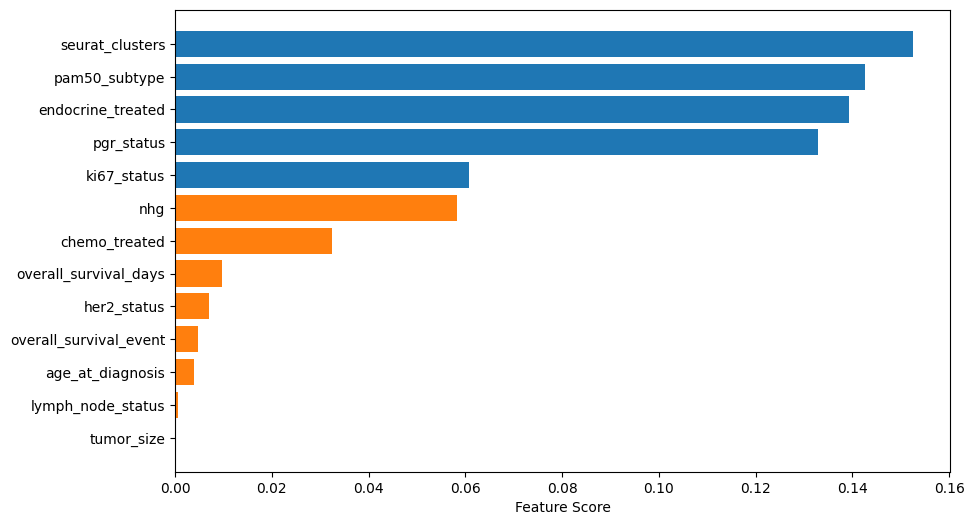

In [11]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
all_features = np.array(categorical_features + numerical_features)

feature_selector = model_pipeline.named_steps['feature_selection']
feature_index = feature_selector.get_support(indices=True)
selected_feature = all_features[feature_index]

feature_importance = pd.DataFrame({
  'Feature': all_features,
  'Score': feature_selector.scores_,
  'Selected': feature_selector.get_support()
}).sort_values('Score', ascending=False)
# display(feature_importance)

plt.figure(figsize=(10, 6))
colors = ['tab:blue' if selected else 'tab:orange' for selected in feature_importance['Selected']]
plt.barh(feature_importance['Feature'], feature_importance['Score'], color=colors)
plt.xlabel('Feature Score')
plt.gca().invert_yaxis()

# fig, ax = plt.subplots(figsize=(10, 6))
# colors = ['tab:green' if selected else 'tab:orange' for selected in feature_importance['Selected']]
# ax.barh(feature_importance['Feature'], feature_importance['Score'], color=colors)
# ax.set_xlabel('Feature Score')
# ax.invert_yaxis()

### Parameter tuning

In [12]:
%%time

model_pipeline = imputation_pipeline(X_train,
                                     classifier= LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced'),
                                     nfeat = 5)

param_grid = [
  {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'newton-cholesky']
  },
  {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
  },
  {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['elasticnet'],
    'classifier__solver': ['saga'],  # saga is the only solver that supports elasticnet
    'classifier__l1_ratio': [0.1, 0.5, 0.7, 0.9]
  }
]

print("Starting Grid Search for Logistic Regression...")
grid_lr = GridSearchCV(
  model_pipeline, 
  param_grid, 
  cv=5, 
  scoring='balanced_accuracy', 
  n_jobs=-1, 
  verbose=1
)

# Fit the grid search
grid_lr.fit(X_train, y_train)

# Display results
print("\nBest parameters:")
print(grid_lr.best_params_)
print(f"\nAveraged cross-validation balanced accuracy score: {grid_lr.best_score_:.3f}")

Starting Grid Search for Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters:
{'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

Averaged cross-validation balanced accuracy score: 0.955
CPU times: user 4.77 s, sys: 612 ms, total: 5.39 s
Wall time: 27.8 s


In [13]:
# Use the best model for predictions
best_model_lr = grid_lr.best_estimator_
y_pred = best_model_lr.predict(X_test)
y_pred_proba = best_model_lr.predict_proba(X_test)

results_lr, html_str = show_results(best_model_lr, X_test, y_pred_proba)

display(results_lr)
display(HTML(html_str))

,Prob_ER+,Prob_ER-,Max_Probability,Predicted_ER_Status,Confidence_Level
Patient_ID,,,,,
F1,0.015638,0.984362,0.984362,ER-,High
F6,0.015638,0.984362,0.984362,ER-,High
F15,0.403025,0.596975,0.596975,ER-,Low
F16,0.015638,0.984362,0.984362,ER-,High
F27,0.023326,0.976674,0.976674,ER-,High
...,...,...,...,...,...
F2962,0.827821,0.172179,0.827821,ER+,High
F2965,0.011873,0.988127,0.988127,ER-,High
F2967,0.988520,0.011480,0.988520,ER+,High


,Label,Count
ER_Status,,
ER+,0,32
ER-,1,168
,Count,Percentage
Confidence_Level,,
High,175,87.5
Medium,16,8.0
Low,9,4.5


### Comparing tuned and untuned model

The tuned model slightly outperformed the untuned one.

In [14]:
print("Default model parameters:", model_pipeline.named_steps['classifier'].get_params())
print("Best tuned parameters:", best_model_lr.named_steps['classifier'].get_params())

# Compare probability distributions
print("\nDefault model confidence distribution:")
print(results['Confidence_Level'].value_counts())
print("\nTuned model confidence distribution:")  
print(results_lr['Confidence_Level'].value_counts())

## compare averaged cross-validated balanced accuracy 
print(f"\nAveraged cross-validated balanced accuracy (untuned model): {cv_scores.mean():.3f}")
print(f"Averaged cross-validation balanced accuracy score (tuned model): {grid_lr.best_score_:.3f}")

Default model parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best tuned parameters: {'C': 100, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Default model confidence distribution:
Confidence_Level
High      174
Medium     18
Low         8
Name: count, dtype: int64

Tuned model confidence distribution:
Confidence_Level
High      175
Medium     16
Low         9
Name: count, dtype: int64

Averaged cross-validated balanced accuracy (untuned model): 0.952
Averaged cross-validation balanced accuracy score (tuned model)

## Random Frorest

In [ ]:
%%time

model_pipeline = imputation_pipeline(X_train,
                                     classifier = RandomForestClassifier(random_state=0, class_weight='balanced'),
                                     nfeat=5)

param_grid = {
  'classifier__n_estimators': [50, 100, 200],
  'classifier__max_depth': [5, 10, 20, 30],
  'classifier__min_samples_split': [2, 5, 10, 20],
  'classifier__min_samples_leaf': [1, 2, 4, 8],
  'classifier__max_features': ['sqrt', 'log2']
}

# from sklearn.tree import DecisionTreeClassifier
# DecisionTreeClassifier(random_state=0)
# param_grid = {
#     'classifier__max_depth': [5, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10, 20],
#     'classifier__min_samples_leaf': [1, 2, 4, 8],
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__max_features': ['sqrt', 'log2']
# }

print("Starting Grid Search for Random Forest...")
grid_rf = GridSearchCV(
  model_pipeline, 
  param_grid, 
  cv=5, 
  scoring='balanced_accuracy', 
  n_jobs=-1, 
  verbose=1
)

# Fit the grid search
grid_rf.fit(X_train, y_train)

# Display results
print("\nBest parameters:")
print(grid_rf.best_params_)
print(f"\nAveraged cross-validation balanced accuracy score: {grid_rf.best_score_:.3f}")

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Best parameters:
{'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}

Averaged cross-validation balanced accuracy score: 0.963
CPU times: user 19 s, sys: 954 ms, total: 19.9 s
Wall time: 3min 27s


In [16]:
# Use the best model for predictions
best_model_rf = grid_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)
y_pred_proba = best_model_rf.predict_proba(X_test)

results_rf, html_str = show_results(best_model_rf, X_test, y_pred_proba)

display(results_rf)
display(HTML(html_str))

,Prob_ER+,Prob_ER-,Max_Probability,Predicted_ER_Status,Confidence_Level
Patient_ID,,,,,
F1,0.081427,0.918573,0.918573,ER-,High
F6,0.081427,0.918573,0.918573,ER-,High
F15,0.790802,0.209198,0.790802,ER+,Medium
F16,0.081427,0.918573,0.918573,ER-,High
F27,0.105113,0.894887,0.894887,ER-,High
...,...,...,...,...,...
F2962,0.837857,0.162143,0.837857,ER+,High
F2965,0.080274,0.919726,0.919726,ER-,High
F2967,0.999465,0.000535,0.999465,ER+,High


,Label,Count
ER_Status,,
ER+,0,38
ER-,1,162
,Count,Percentage
Confidence_Level,,
High,176,88.0
Medium,23,11.5
Low,1,0.5


## SVM

In [17]:
%%time

model_pipeline = imputation_pipeline(X_train, 
                                     classifier= SVC(probability=True, class_weight='balanced'),
                                     nfeat=5) 


param_grid = [
  # Grid for Linear kernel
  {
    'classifier__kernel': ['linear'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
  },
  # Grid for RBF kernel
  {
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': [0.01, 0.1, 1, 10, 100]
  },
  # Grid for Polynomial kernel
  {
    'classifier__kernel': ['poly'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__degree': [2, 3, 4, 5]
  }
]

print("Starting Grid Search for SVM...")
grid_svm = GridSearchCV(
  model_pipeline, 
  param_grid, 
  cv=5, 
  scoring='balanced_accuracy', 
  n_jobs=-1, 
  verbose=1
)

# Fit the grid search
grid_svm.fit(X_train, y_train)

# Display results
print("\nBest parameters:")
print(grid_svm.best_params_)
print(f"\nAveraged cross-validation balanced accuracy score: {grid_svm.best_score_:.3f}")


Starting Grid Search for SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters:
{'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}

Averaged cross-validation balanced accuracy score: 0.961
CPU times: user 5.21 s, sys: 419 ms, total: 5.63 s
Wall time: 40.1 s


In [18]:
# Use the best model for predictions
best_model_svm = grid_svm.best_estimator_
y_pred = best_model_svm.predict(X_test)
y_pred_proba = best_model_svm.predict_proba(X_test)

results_svm, html_str = show_results(best_model_svm, X_test, y_pred_proba)

display(results_svm)
display(HTML(html_str))

,Prob_ER+,Prob_ER-,Max_Probability,Predicted_ER_Status,Confidence_Level
Patient_ID,,,,,
F1,0.144080,0.855920,0.855920,ER-,High
F6,0.144080,0.855920,0.855920,ER-,High
F15,0.972072,0.027928,0.972072,ER+,High
F16,0.144080,0.855920,0.855920,ER-,High
F27,0.370919,0.629081,0.629081,ER-,Medium
...,...,...,...,...,...
F2962,0.979503,0.020497,0.979503,ER+,High
F2965,0.126436,0.873564,0.873564,ER-,High
F2967,0.999174,0.000826,0.999174,ER+,High


,Label,Count
ER_Status,,
ER+,0,27
ER-,1,173
,Count,Percentage
Confidence_Level,,
High,147,73.5
Medium,40,20.0
Low,13,6.5


## Results

Below we populate the original dataset with the predicted ER staus and the imputed values obtained by the best model (random forest) according to the averaged balanced accuracy.

In [51]:
pd.DataFrame({
  'Model': ['Logistic Regression',
            'Random Forest',
            'SVM'],
  'Avg_Balanced_Accuracy': [f"{grid_lr.best_score_:.3f}", 
                            f"{grid_rf.best_score_:.3f}", 
                            f"{grid_svm.best_score_:.3f}"],
}).set_index('Model').sort_values('Avg_Balanced_Accuracy', ascending=False)

,Avg_Balanced_Accuracy
Model,
Random Forest,0.963
SVM,0.961
Logistic Regression,0.955


In [ ]:
# get imputer for the best model
imputer = best_model_rf.named_steps['imputation']

# get fitted imputations
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# split imputed data back into numerical and categorical parts
# nb: the slicing order is defined by ColumnTransformer in imputation_pipeline() -> categorical come before numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

n_cat = len(cat_features)
n_num = len(num_features)

X_train_cat = X_train_imputed[:, :n_cat]
X_train_num = X_train_imputed[:, n_cat:n_num+n_cat]

X_test_cat = X_test_imputed[:, :n_cat]
X_test_num = X_test_imputed[:, n_cat:n_num+n_cat]

# get the ordinal encoder from the categorical transformer
categorical_transformer = imputer.named_transformers_['categorical']
ordinal_encoder = categorical_transformer.named_steps['encoder']

# inverse transform categorical features to get original labels
X_train_cat = ordinal_encoder.inverse_transform(X_train_cat)
X_test_cat = ordinal_encoder.inverse_transform(X_test_cat)

# create dataframes with original categorical values and processed numerical values
X_train_imputed = pd.DataFrame(
  np.column_stack([X_train_cat, X_train_num]),
  columns=cat_features + num_features,
  index=X_train.index
)

X_train_imputed = X_train_imputed[X_train.columns]

X_test_imputed = pd.DataFrame(
  np.column_stack([X_test_cat, X_test_num]),
  columns=cat_features + num_features,
  index=X_test.index
)

X_test_imputed = X_test_imputed[X_test.columns]

## NaN comparison
# print("Training set - original data:")
# display(X_train[X_train.isnull().any(axis=1)])

# print("\nTraining set - after imputation:")
# display(X_train_imputed[X_train.isnull().any(axis=1)])

# print("\nTest set - original data:")
# display(X_test[X_test.isnull().any(axis=1)])

# print("\nTest set - after imputation:")
# display(X_test_imputed[X_test.isnull().any(axis=1)])
## 

## complete dataset with the predicted ER status and the imputed values.
pred_er = results_svm[['Predicted_ER_Status']].rename(columns={'Predicted_ER_Status': 'er_status'})
pred_er.index.name = 'patient'
X_test_complete = pd.concat([X_test_imputed, pred_er], axis=1)

train_er = df.loc[~y.isna(), ['er_status']]
X_train_complete = pd.concat([X_train_imputed, train_er], axis=1)

display(pd.concat([X_train_complete, X_test_complete]).reindex(df.index))

## check
print("\nTot. missing values including training and test:")
print("Before imputation:", X_train.isnull().sum().sum() + X_test.isnull().sum().sum())
print("After imputation:", X_train_imputed.isnull().sum().sum() + X_test_imputed.isnull().sum().sum())

,age_at_diagnosis,tumor_size,lymph_node_status,pgr_status,her2_status,pam50_subtype,overall_survival_days,overall_survival_event,endocrine_treated,chemo_treated,ki67_status,nhg,seurat_clusters,er_status
patient,,,,,,,,,,,,,,
F1,-1.51916,-0.904251,NodeNegative,PgR+,HER2-,Basal,1.604754,nosurvival,untreated,treated,Ki67+,G3,0.668592,ER-
F2,-1.135531,-0.482241,NodePositive,PgR+,HER2-,LumA,1.604754,nosurvival,treated,treated,Ki67+,G2,-1.249785,ER+
F3,0.47571,0.614988,NodePositive,PgR+,HER2-,LumB,1.197026,survival,treated,treated,Ki67+,G3,-0.86611,ER+
F4,-1.826063,2.64064,NodePositive,PgR+,HER2+,LumA,1.705149,nosurvival,treated,treated,Ki67+,G3,0.284916,ER+
F5,0.782613,3.40026,NodePositive,PgR+,HER2-,Normal,1.64983,nosurvival,treated,untreated,Ki67+,G2,-0.098759,ER+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F3269,0.705887,-0.566643,NodeNegative,PgR+,HER2-,LumB,-1.491111,nosurvival,treated,treated,Ki67+,G2,1.435942,ER+
F3270,0.47571,0.868194,NodePositive,PgR+,HER2-,LumA,-1.480866,nosurvival,treated,treated,Ki67+,G2,1.819618,ER+
F3271,0.782613,-0.144632,NodeNegative,PgR-,HER2+,LumB,-1.478817,nosurvival,treated,treated,Ki67+,G3,0.284916,ER+



Tot. missing values including training and test:
Before imputation: 2407
After imputation: 0
